Cristobal Alcaino


Voy a intentar replicar los codigos de Zapata pero descartando algunas variables irrelevantes para ver como anda el rendimiento. De igual forma voy a intentar hacer join-merge con los datos entregados anteriormente para ver si mejoramos la precisión.

In [1]:
# importacion de datos
# esto es full zapit
import pandas as pd
df_sc = pd.read_excel("BBDD/SC_COTIZACIONES.xlsx")
df = pd.read_excel("BBDD/COTIZACIONES.xlsx")
cotizantes_comunes = pd.merge(df, df_sc, on=['COTIZANTE', 'COTIZACION'], how='inner')


Realizacion modelo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import shap
import joblib

c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# configuracion inicial
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')


In [ ]:
def preprocess_data(df, sample_size = None, random_state = 42):
    if sample_size:
        df = df.sample(n=sample_size, random_state=random_state).copy()

    cols_to_convert = [
        "COTIZACION", "RENTA", "PRIMA_UNICA",
        "RETENCION_AFP", "RETIRO_EXCEDENTES", "TIT_PROPUESTA",
        "TIT_MAXIMA", "PORCENTAJE_COMISION"
    ]

    for col in cols_to_convert:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)

    categorical_cols = ["TIPO_RENTA", "MODALIDAD_RENTA", "SEGMENTO", "NOMBRE_SEGMENTO"]
    categorical_cols = [col for col in categorical_cols if col in df.columns]

    df[categorical_cols] = df[categorical_cols].astype("category")
    df_encoded = pd.get_dummies(df, columns = categorical_cols, drop_first=True)
    
    X = df_encoded.drop(columns = ["POSICION_RELATIVA", "FECHA_COTIZACION"])
    y = df["POSICION_RELATIVA"].astype(int)

    X["index_original"] = df.index
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X.drop(columns=["index_original"])),
                             columns=X.columns[:-1])
    X_imputed["index_original"] = X["index_original"].values

    # filtremos clases con al menos 2 observaciones
    conteo_clases = y.value_counts()
    clases_validas = conteo_clases[conteo_clases >= 10].index
    filtro_validas = y.isin(clases_validas)

    X_final = X_imputed[filtro_validas].reset_index(drop=True)
    y_final = y[filtro_validas].reset_index(drop=True)

    return X_final, y_final



In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [38]:
def select_features(X, y, threshold=0.01, plot = True):
    clf_temp = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf_temp.fit(X,y)

    importances = clf_temp.feature_importances_
    indices = np.argsort(importances)[::-1]

    if plot:
        plt.figure(figsize=(12, 8))
        plt.title("Importancia de Caracteristicas")
        plt.bar(range(X.shape[1]), importances[indices], align = "center")
        plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation = 90)
        plt.xlim([-1, X.shape[1]])
        plt.tight_layout()
        plt.show()

    selected = [col for col, imp in zip(X.columns, importances) if imp > threshold]
    print(f"Se seleccionaron {len(selected)} caracteristicas de {X.shape[1]} posibles")
    return selected

def train_random_forest(X_train, y_train, optimize=False, n_jobs=-1, n_iter=5):
    if optimize:
        print("Optimizando hiperparametros con GridSearchCV")
        param_dist = {
            'n_estimators':randint(10,20),
            'max_depth':randint(5, 10),
            'min_samples_leaf': randint(1, 10),
            'max_features':['sqrt', 'log2', None],
            'class_weight':['balanced', 'balanced_subsample']
        }

        random_search = RandomizedSearchCV(
            estimator = RandomForestClassifier(random_state=42),
            param_distributions=param_dist,
            n_iter=n_iter,
            cv = 3,
            scoring='f1_weighted',
            random_state=42,
            n_jobs=n_jobs,
            verbose=2
        )
        random_search.fit(X_train, y_train)
        print(f"Mejores parametros:{random_search.best_params_}")
        print(f"Mejor puntuacion:{random_search.best_score_:.4f}")

        return random_search.best_estimator_
    ## aca hay q optimizar los hiperparametros
    ## voy a completar esta despues lol
    else:
        print("Entrenando por defecto")
        clf = RandomForestClassifier(n_estimators=200, 
                                    max_depth=30,
                                    min_samples_split=5,
                                    max_features='sqrt',
                                    class_weight='balanced_subsample',
                                    random_state=42, 
                                    n_jobs=-1
                                )
        clf.fit(X_train, y_train)
        return clf

def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)

    print("\nReport de Clasificacion:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusion")
    plt.show()

    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(10, 6))
    plt.title("Top 20 caracteristicas importantes")
    plt.barh(range(len(indices)), importances[indices][::-1], align="center")
    plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices[::-1]])
    plt.xlabel("importancia relativa")
    plt.tight_layout()
    plt.show()

    return y_pred, y_prob

def explain_model(clf, X_train, X_sample):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, plot_type="bar", class_names=clf.classes_)

    for col in X_train.columns[:3]:
        shap.dependence_plot(col, shap_values[0], X_sample, interaction_index=None)
    return explainer


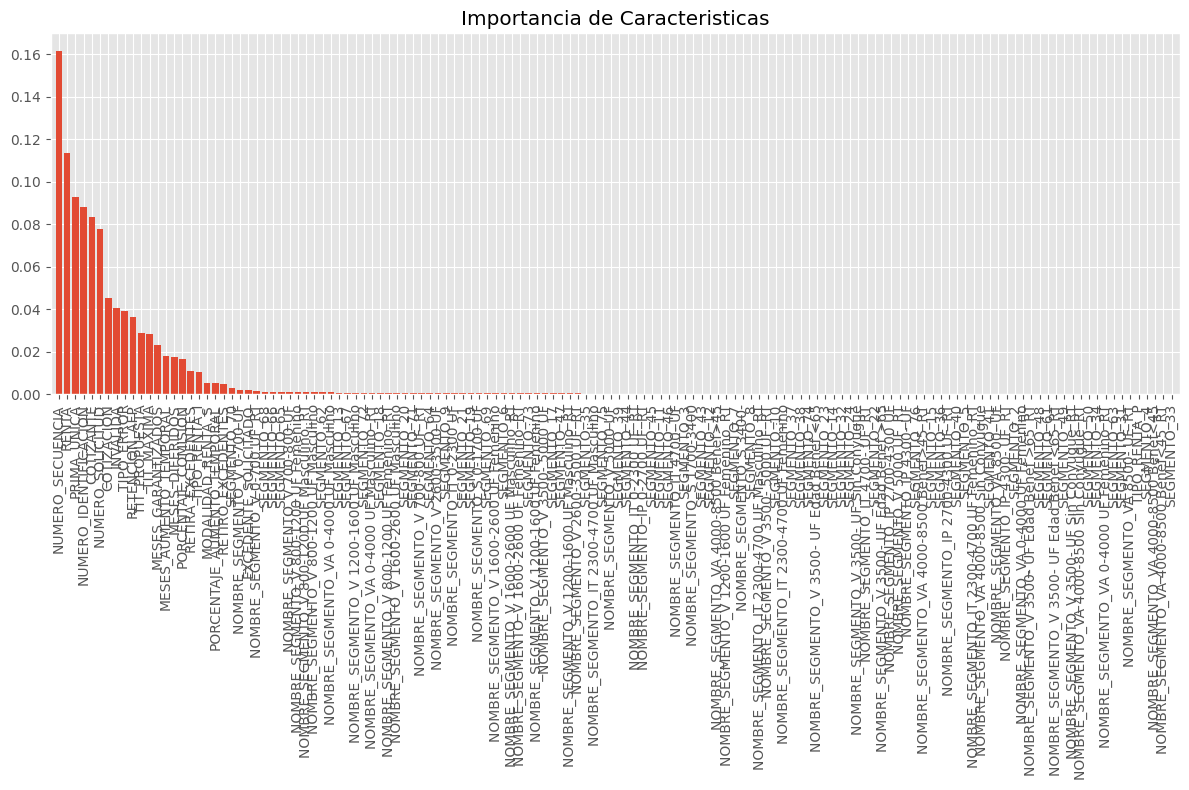

Se seleccionaron 18 caracteristicas de 136 posibles


TypeError: select_features() missing 1 required positional argument: 'y'

In [ ]:
X, y = preprocess_data(df_sc, None)
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=["index_original"]),
    y, 
    test_size=0.2,
    stratify=y, 
    random_state=42
)

index_test = X.loc[X_test.index, "index_original"]

selected_features = select_features(X_train, y_train)


In [25]:
top_n = 5
top_features = selected_features[top_n-1:10]
print(f"Usando los siguientes features mas importantes:")
print(top_features)

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


Usando los siguientes features mas importantes:
['MESES_GARANTIZADOS', 'MESES_AUMENTO_TEMPORAL', 'RETIRA_EXCEDENTES', 'PORCENTAJE_COMISION', 'COTIZANTE', 'COTIZACION']


In [26]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_sel.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_sel.columns)


Entrenando por defecto

Report de Clasificacion:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     79845
           1       0.66      0.76      0.71     15718
           2       0.69      0.68      0.69     29611
           3       0.59      0.55      0.57     24417
           4       0.61      0.57      0.59     20907
           5       0.53      0.56      0.54     12116
           6       0.50      0.56      0.53      6410
           7       0.48      0.54      0.51      2712
           8       0.48      0.45      0.46       710
           9       0.51      0.38      0.43       135
          10       0.00      0.00      0.00         5

    accuracy                           0.77    192586
   macro avg       0.55      0.55      0.55    192586
weighted avg       0.77      0.77      0.77    192586



c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

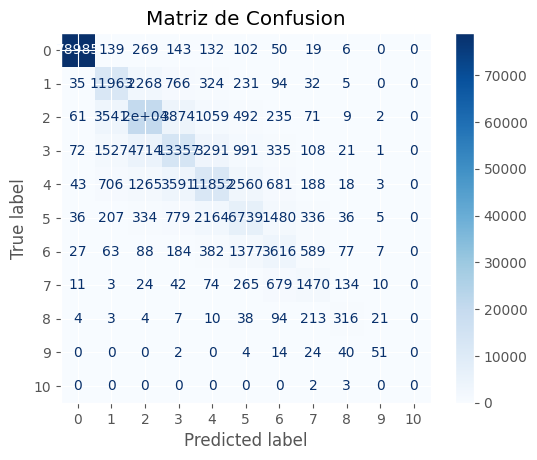

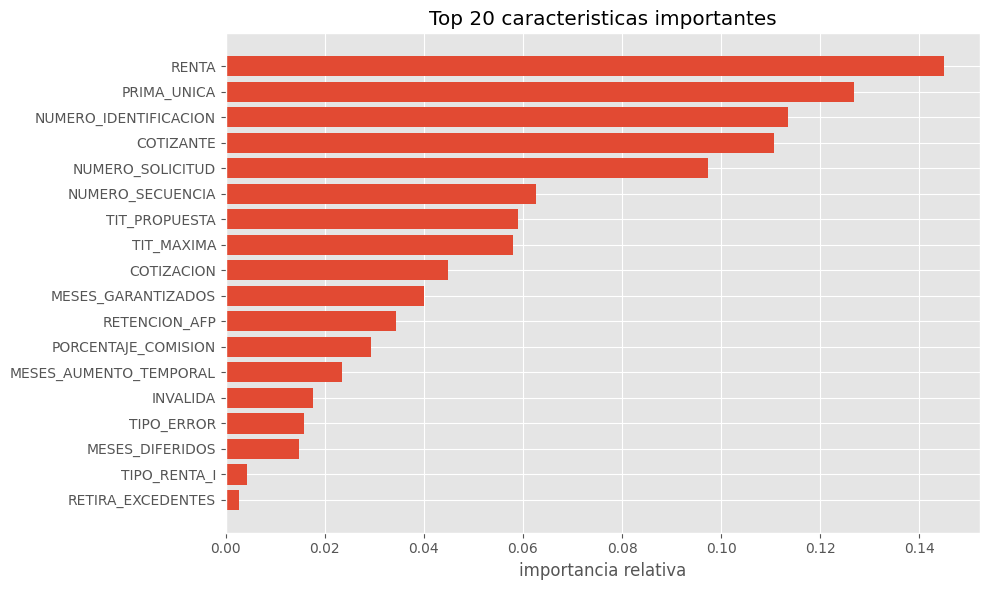

In [39]:
clf = train_random_forest(X_train_scaled, y_train, optimize=False)
y_pred, y_prob = evaluate_model(clf, X_test_scaled, y_test)

Le meti una profundidad de 30 y mejoro en 1%. Infimo.
Mal. 